### Model Training

In [51]:
import numpy as np
import pandas as pd
import pandasql as ps
import math
import itertools 
from scipy import stats
import time
import os

# Parallel processing
from joblib import Parallel, delayed
from tqdm import tqdm

#matplotlib libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors
import seaborn as sns

#date libraries
from dateutil import parser
from datetime import datetime, timedelta, date
import holidays

#prophet library
from prophet import Prophet
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import cross_validation

#pandas options
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#matplotlib setting defaults
sns.set(font="Arial",
        rc={
 "axes.axisbelow": False,
 "axes.edgecolor": "lightgrey",
 "axes.facecolor": "None",
 "axes.grid": False,
 "axes.labelcolor": "dimgrey",
 "axes.spines.right": False,
 "axes.spines.top": False,
 "figure.facecolor": "white",
 "lines.solid_capstyle": "round",
 "patch.edgecolor": "w",
 "patch.force_edgecolor": True,
 "text.color": "dimgrey",
 "xtick.bottom": False,
 "xtick.color": "dimgrey",
 "xtick.direction": "out",
 "xtick.top": False,
 "ytick.color": "dimgrey",
 "ytick.direction": "out",
 "ytick.left": False,
 "ytick.right": False})

In [52]:
def missing_data(input_data):
    '''
    This function returns dataframe with information about the percentage of nulls in each column and the column data type.
    
    input: pandas df
    output: pandas df
    
    '''
    
    total = input_data.isnull().sum()
    percent = (input_data.isnull().sum()/input_data.isnull().count()*100)
    table = pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent'])
    types = []
    for col in input_data.columns: 
        dtype = str(input_data[col].dtype)
        types.append(dtype)
    table["Types"] = types
    return(pd.DataFrame(table))

def mape(actual, pred): 
    '''
    Mean Absolute Percentage Error (MAPE) Function
    
    input: list/series for actual values and predicted values
    output: mape value 
    '''
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

#### Import csv 


In [53]:
df = pd.read_csv('dataset/restaurant_sales_data.csv')

In [54]:
# Fix the date conversion - use ISO8601 format or let pandas infer
df['date'] = pd.to_datetime(df['date'])  # Let pandas auto-detect the format

# Or explicitly use the correct format if dates are like "2024-01-15"
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df.head(1)

,date,restaurant_id,restaurant_type,menu_item_name,meal_type,key_ingredients_tags,typical_ingredient_cost,observed_market_price,actual_selling_price,quantity_sold,has_promotion,special_event,weather_condition
0,2024-01-01,11,Food Stall,Laksa,Lunch,"rice noodles, fish broth, tamarind, shrimp pas...",4.50,10.59,12.48,361,False,False,Sunny


In [55]:
min(df['date']), max(df['date'])

(Timestamp('2024-01-01 00:00:00'), Timestamp('2025-01-01 00:00:00'))

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   date                     10000 non-null  datetime64[ns]
 1   restaurant_id            10000 non-null  int64         
 2   restaurant_type          10000 non-null  object        
 3   menu_item_name           10000 non-null  object        
 4   meal_type                10000 non-null  object        
 5   key_ingredients_tags     10000 non-null  object        
 6   typical_ingredient_cost  10000 non-null  float64       
 7   observed_market_price    10000 non-null  float64       
 8   actual_selling_price     10000 non-null  float64       
 9   quantity_sold            10000 non-null  int64         
 10  has_promotion            10000 non-null  bool          
 11  special_event            10000 non-null  bool          
 12  weather_condition        10000 no

In [57]:
# Convert restaurant_id to categorical string format (R001, R002, etc.)
df['restaurant_id'] = 'R' + df['restaurant_id'].astype(str).str.zfill(3)

# Convert categorical columns to category dtype for memory efficiency
categorical_columns = ['restaurant_id', 'restaurant_type', 'menu_item_name', 
                       'meal_type', 'weather_condition', 'key_ingredients_tags']

for col in categorical_columns:
    df[col] = df[col].astype('category')

# Verify the changes
print("Data types after conversion:")
print(df.info())


Data types after conversion:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   date                     10000 non-null  datetime64[ns]
 1   restaurant_id            10000 non-null  category      
 2   restaurant_type          10000 non-null  category      
 3   menu_item_name           10000 non-null  category      
 4   meal_type                10000 non-null  category      
 5   key_ingredients_tags     10000 non-null  category      
 6   typical_ingredient_cost  10000 non-null  float64       
 7   observed_market_price    10000 non-null  float64       
 8   actual_selling_price     10000 non-null  float64       
 9   quantity_sold            10000 non-null  int64         
 10  has_promotion            10000 non-null  bool          
 11  special_event            10000 non-null  bool          
 12  weat

In [58]:
total_sales_df = df.groupby('date')['quantity_sold'].sum().reset_index()
total_sales_df.head()

,date,quantity_sold
0,2024-01-01,8479
1,2024-01-02,7647
2,2024-01-03,4172
3,2024-01-04,7592
4,2024-01-05,6712


In [59]:
old_len = len(total_sales_df.columns)

In [60]:
missing_data(total_sales_df).head()

,Total,Percent,Types
date,0,0.00,datetime64[ns]
quantity_sold,0,0.00,int64


Total data points: 367
Dropping 5 outlier rows (z-score > 2.7)
Outlier percentage: 1.36%
Remaining data points: 362

Data range: 2024-01-01 00:00:00 to 2025-01-01 00:00:00
Mean daily sales: 7680
Std daily sales: 2399


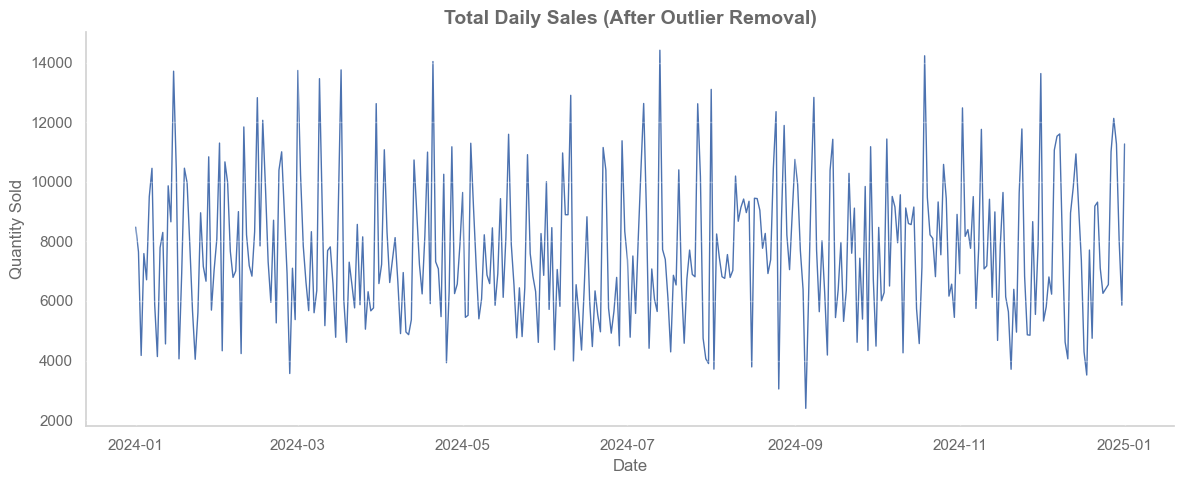

In [61]:
# Cleaning up dataframe using z-score to remove outliers which heavily bias the model
# Since we're forecasting total sales, we only have one time series

df_clean = total_sales_df.copy()

# Calculate z-score for quantity_sold
z = np.abs(stats.zscore(df_clean['quantity_sold']))
outlier_index = np.where(z > 2.7)[0]  # 99.7% of data within 3 std deviations

print(f"Total data points: {len(df_clean)}")
print(f"Dropping {len(outlier_index)} outlier rows (z-score > 2.7)")
print(f"Outlier percentage: {len(outlier_index)/len(df_clean)*100:.2f}%")

# Remove outliers
df_clean = df_clean.drop(df_clean.index[outlier_index]).reset_index(drop=True)

print(f"Remaining data points: {len(df_clean)}")
print(f"\nData range: {df_clean['date'].min()} to {df_clean['date'].max()}")
print(f"Mean daily sales: {df_clean['quantity_sold'].mean():.0f}")
print(f"Std daily sales: {df_clean['quantity_sold'].std():.0f}")

# Visualize cleaned data
plt.figure(figsize=(12, 5))
plt.plot(df_clean['date'], df_clean['quantity_sold'], linewidth=1)
plt.title('Total Daily Sales (After Outlier Removal)', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Quantity Sold')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [62]:
# ==========================================
# CORRECTED CROSS-VALIDATION SETUP
# ==========================================

# dataset: ~365 days (Jan 2024 - Jan 2025)
# Need to leave room for testing!

initial = '270 days'      # Use first ~9 months (74%) for training
period = '30 days'        # Move forward 30 days for each fold
horizon = '30 days'       # Forecast 30 days ahead

# This creates approximately 3 validation windows:
# Window 1: Train on days 1-270, test on days 271-300
# Window 2: Train on days 1-300, test on days 301-330
# Window 3: Train on days 1-330, test on days 331-360

print("=" * 60)
print("CROSS-VALIDATION CONFIGURATION")
print("=" * 60)
print(f"Total data: ~365 days")
print(f"Initial training: {initial} (~74% of data)")
print(f"Period: {period}")
print(f"Horizon: {horizon}")
print(f"Number of CV folds: ~3")
print(f"Data used for validation: ~90 days (last 25%)")

CROSS-VALIDATION CONFIGURATION
Total data: ~365 days
Initial training: 270 days (~74% of data)
Period: 30 days
Horizon: 30 days
Number of CV folds: ~3
Data used for validation: ~90 days (last 25%)


### HYPERPARAMETER TUNING AND BACKTESTING PIPELINE
Ranges give on Prophet's documentation
1. changepoint_prior_scale [0.001, 0.5] 
2. seasonality_prior_scale [0.01, 10] 
3. holidays_prior_scale [0.01, 10] 
4. seasonality_mode ['additive', 'multiplicative']. 
5. changepoint_range [0.5, 0.95] 

https://facebook.github.io/prophet/docs/diagnostics.html

In [63]:
# OPTIMIZED HYPERPARAMETER RANGES - Reduced for faster tuning
# Focus on most impactful parameters with fewer values

param_grid = {
    'changepoint_prior_scale': [0.05, 0.5],           # 2 values - flexibility of trend
    'seasonality_prior_scale': [1.0, 10.0],           # 2 values - strength of seasonality  
    'seasonality_mode': ['additive', 'multiplicative'] # 2 values - how seasonality combines
}

# Calculate total combinations
total_combinations = (
    len(param_grid['changepoint_prior_scale']) *
    len(param_grid['seasonality_prior_scale']) *
    len(param_grid['seasonality_mode'])
)

print("=" * 60)
print("OPTIMIZED HYPERPARAMETER TUNING CONFIGURATION")
print("=" * 60)
print(f"Total combinations: {total_combinations} (was 2000)")
print(f"Estimated time: ~{total_combinations * 1:.0f}-{total_combinations * 2:.0f} minutes")
print(f"                ({total_combinations * 1/60:.1f}-{total_combinations * 2/60:.1f} hours)")
print("\nParameter ranges:")
for param, values in param_grid.items():
    print(f"  {param}: {values}")
print("\nNote: Using Prophet defaults for holidays_prior_scale=10.0, changepoint_range=0.8")

OPTIMIZED HYPERPARAMETER TUNING CONFIGURATION
Total combinations: 8 (was 2000)
Estimated time: ~8-16 minutes
                (0.1-0.3 hours)

Parameter ranges:
  changepoint_prior_scale: [0.05, 0.5]
  seasonality_prior_scale: [1.0, 10.0]
  seasonality_mode: ['additive', 'multiplicative']

Note: Using Prophet defaults for holidays_prior_scale=10.0, changepoint_range=0.8


In [64]:
# OPTIMIZED HYPERPARAMETER TUNING WITH CROSS-VALIDATION
import warnings
warnings.filterwarnings('ignore')

# Prepare data for Prophet
prophet_df = df_clean[['date', 'quantity_sold']].copy()
prophet_df.columns = ['ds', 'y']
prophet_df = prophet_df.sort_values('ds').reset_index(drop=True)

print("=" * 60)
print("STARTING HYPERPARAMETER TUNING")
print("=" * 60)
print(f"Data: {len(prophet_df)} days")
print(f"Date range: {prophet_df['ds'].min().date()} to {prophet_df['ds'].max().date()}")
print(f"Mean sales: {prophet_df['y'].mean():.0f}")

# Adjust CV parameters based on available data
total_days = (prophet_df['ds'].max() - prophet_df['ds'].min()).days

if total_days < 365:
    cv_initial = f"{int(total_days * 0.6)} days"
    cv_period = f"{max(14, int(total_days * 0.1))} days"
    cv_horizon = f"{max(14, int(total_days * 0.1))} days"
    print(f"\n⚠️  Adjusted CV: initial={cv_initial}, period={cv_period}, horizon={cv_horizon}")
else:
    cv_initial = '270 days'
    cv_period = '30 days'
    cv_horizon = '30 days'
    print(f"\nCV: initial={cv_initial}, period={cv_period}, horizon={cv_horizon}")

# Generate all parameter combinations
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

results = []
start_time = time.time()

print(f"\nTesting {len(all_params)} combinations...")
print("-" * 60)

for idx, params in enumerate(all_params, 1):
    try:
        # Train model with optimized parameters
        m = Prophet(
            changepoint_prior_scale=params['changepoint_prior_scale'],
            seasonality_prior_scale=params['seasonality_prior_scale'],
            seasonality_mode=params['seasonality_mode'],
            holidays_prior_scale=10.0,      # Use Prophet default
            changepoint_range=0.8,           # Use Prophet default
            daily_seasonality=False,
            weekly_seasonality=True,
            yearly_seasonality=True
        )
        m.fit(prophet_df)
        
        # Cross-validation WITHOUT parallel processing (faster for small grids)
        df_cv = cross_validation(
            m,
            initial=cv_initial,
            period=cv_period,
            horizon=cv_horizon
        )
        
        # Performance metrics
        df_p = performance_metrics(df_cv, rolling_window=1)
        
        # Store results
        result = params.copy()
        result['mape'] = df_p['mape'].mean()
        result['rmse'] = df_p['rmse'].mean()
        result['mae'] = df_p['mae'].mean()
        results.append(result)
        
        # Progress update
        elapsed = time.time() - start_time
        avg_time = elapsed / idx
        remaining = avg_time * (len(all_params) - idx)
        
        print(f"[{idx}/{len(all_params)}] MAPE: {result['mape']:.2f}% | "
              f"Elapsed: {elapsed/60:.1f}m | ETA: {remaining/60:.1f}m", end='\r')
        
    except Exception as e:
        print(f"[{idx}/{len(all_params)}] FAILED: {str(e)[:50]}", end='\r')
        continue

print("\n" + "=" * 60)
print("TUNING COMPLETE!")
print("=" * 60)

# Create results dataframe
results_df = pd.DataFrame(results).sort_values('mape').reset_index(drop=True)

print(f"\n✅ Successfully tested {len(results_df)}/{len(all_params)} combinations")
print(f"⏱️  Total time: {(time.time() - start_time)/60:.2f} minutes")
print(f"\n📊 Top 5 Results:")
print(results_df.head(5).to_string(index=False))

print(f"\n🎯 Best Parameters:")
best = results_df.iloc[0].to_dict()
for param, value in best.items():
    print(f"  {param}: {value}")




23:07:04 - cmdstanpy - INFO - Chain [1] start processing


STARTING HYPERPARAMETER TUNING
Data: 362 days
Date range: 2024-01-01 to 2025-01-01
Mean sales: 7680

CV: initial=270 days, period=30 days, horizon=30 days

Testing 8 combinations...
------------------------------------------------------------


23:07:04 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/3 [00:00<?, ?it/s]23:07:04 - cmdstanpy - INFO - Chain [1] start processing
23:07:04 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  5.18it/s]23:07:05 - cmdstanpy - INFO - Chain [1] start processing
23:07:05 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  4.80it/s]23:07:05 - cmdstanpy - INFO - Chain [1] start processing
23:07:05 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:00<00:00,  4.91it/s]
23:07:05 - cmdstanpy - INFO - Chain [1] start processing
23:07:05 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]23:07:05 - cmdstanpy - INFO - Chain [1] start processing
23:07:05 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  4.93it/s]23:07:05 - cmdstanpy - INFO - Chain [1] start processing
23:07:05 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  5.10it/s]23:07:06 - cmdstanpy - INFO - Chain [1] start processing
23:07:06 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:00<00:00,  4.95it/s]
23:07:06 - cmdstanpy - INFO - Chain [1] start processing
23:07:06 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]23:07:06 - cmdstanpy - INFO - Chain [1] start processing
23:07:06 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  5.30it/s]23:07:06 - cmdstanpy - INFO - Chain [1] start processing
23:07:06 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  5.14it/s]23:07:06 - cmdstanpy - INFO - Chain [1] start processing
23:07:06 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:00<00:00,  5.14it/s]
23:07:07 - cmdstanpy - INFO - Chain [1] start processing
23:07:07 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]23:07:07 - cmdstanpy - INFO - Chain [1] start processing
23:07:07 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  5.02it/s]23:07:07 - cmdstanpy - INFO - Chain [1] start processing
23:07:07 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  5.10it/s]23:07:07 - cmdstanpy - INFO - Chain [1] start processing
23:07:07 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:00<00:00,  5.08it/s]
23:07:07 - cmdstanpy - INFO - Chain [1] start processing
23:07:07 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]23:07:08 - cmdstanpy - INFO - Chain [1] start processing
23:07:08 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  5.40it/s]23:07:08 - cmdstanpy - INFO - Chain [1] start processing
23:07:08 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  5.22it/s]23:07:08 - cmdstanpy - INFO - Chain [1] start processing
23:07:08 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:00<00:00,  5.17it/s]
23:07:08 - cmdstanpy - INFO - Chain [1] start processing
23:07:08 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]23:07:08 - cmdstanpy - INFO - Chain [1] start processing
23:07:08 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  4.92it/s]23:07:09 - cmdstanpy - INFO - Chain [1] start processing
23:07:09 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  4.97it/s]23:07:09 - cmdstanpy - INFO - Chain [1] start processing
23:07:09 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:00<00:00,  4.86it/s]
23:07:09 - cmdstanpy - INFO - Chain [1] start processing
23:07:09 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]23:07:09 - cmdstanpy - INFO - Chain [1] start processing
23:07:09 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  5.01it/s]23:07:09 - cmdstanpy - INFO - Chain [1] start processing
23:07:09 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  5.13it/s]23:07:10 - cmdstanpy - INFO - Chain [1] start processing
23:07:10 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:00<00:00,  5.03it/s]
23:07:10 - cmdstanpy - INFO - Chain [1] start processing
23:07:10 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]23:07:10 - cmdstanpy - INFO - Chain [1] start processing
23:07:10 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  5.15it/s]23:07:10 - cmdstanpy - INFO - Chain [1] start processing
23:07:10 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  5.09it/s]23:07:10 - cmdstanpy - INFO - Chain [1] start processing
23:07:10 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:00<00:00,  5.03it/s]

[8/8] MAPE: 0.35% | Elapsed: 0.1m | ETA: 0.0m
TUNING COMPLETE!

✅ Successfully tested 8/8 combinations
⏱️  Total time: 0.11 minutes

📊 Top 5 Results:
 changepoint_prior_scale  seasonality_prior_scale seasonality_mode  mape    rmse     mae
                    0.05                     1.00   multiplicative  0.32 2848.19 2285.48
                    0.05                    10.00   multiplicative  0.32 2852.30 2288.15
                    0.50                     1.00   multiplicative  0.34 2860.95 2182.47
                    0.05                     1.00         additive  0.34 3039.96 2489.89
                    0.05                    10.00         additive  0.34 3044.67 2492.79

🎯 Best Parameters:
  changepoint_prior_scale: 0.05
  seasonality_prior_scale: 1.0
  seasonality_mode: multiplicative
  mape: 0.32432235309623264
  rmse: 2848.1858081922305
  mae: 2285.4778944637233


In [65]:
##accuracy in %
accuracy = 100 - best['mape']
print(f"  Accuracy: {accuracy:.2f}%")

  Accuracy: 99.68%


#### Adding Holiday Data for Singapore


In [66]:
# Adding holiday data for Singapore
# Singapore holidays for the years in our dataset (2024-2025)

singapore_holidays_df = pd.DataFrame([])

# Get Singapore holidays
singapore_holidays = holidays.country_holidays('SG')  # Singapore country code

# Extract years from our dataset
min_year = df_clean['date'].min().year
max_year = df_clean['date'].max().year
years_range = list(range(min_year, max_year + 2))  # +2 to include forecast period

print(f"Preparing Singapore holidays for years: {years_range}")

# Create holiday dataframe
for date_, name in sorted(holidays.SG(years=years_range).items()):
    singapore_holidays_df = pd.concat([
        singapore_holidays_df, 
        pd.DataFrame({
            'ds': date_, 
            'holiday': 'SG-Holiday',
            'lower_window': -2,  # Include 2 days before holiday
            'upper_window': 1    # Include 1 day after holiday
        }, index=[0])
    ], ignore_index=True)

# Convert to datetime
singapore_holidays_df['ds'] = pd.to_datetime(singapore_holidays_df['ds'], format='%Y-%m-%d', errors='ignore')

print(f"\n✅ Total Singapore holidays loaded: {len(singapore_holidays_df)}")
print(f"Date range: {singapore_holidays_df['ds'].min().date()} to {singapore_holidays_df['ds'].max().date()}")
print("\nFirst few holidays:")
print(singapore_holidays_df.head(10))

Preparing Singapore holidays for years: [2024, 2025, 2026]

✅ Total Singapore holidays loaded: 38
Date range: 2024-01-01 to 2026-12-25

First few holidays:
          ds     holiday  lower_window  upper_window
0 2024-01-01  SG-Holiday            -2             1
1 2024-02-10  SG-Holiday            -2             1
2 2024-02-11  SG-Holiday            -2             1
3 2024-02-12  SG-Holiday            -2             1
4 2024-03-29  SG-Holiday            -2             1
5 2024-04-10  SG-Holiday            -2             1
6 2024-05-01  SG-Holiday            -2             1
7 2024-05-22  SG-Holiday            -2             1
8 2024-06-17  SG-Holiday            -2             1
9 2024-08-09  SG-Holiday            -2             1


### FINAL FORECASTING - Future Predictions (30 Days)

FINAL FORECASTING - FUTURE PREDICTIONS
Using all available data: 362 days
Last date in dataset: 2025-01-01
Forecasting next 30 days
Forecast end date: 2025-01-31

Training final model on full dataset...


23:07:11 - cmdstanpy - INFO - Chain [1] start processing
23:07:11 - cmdstanpy - INFO - Chain [1] done processing


✅ Model trained successfully!
Total predictions generated: 392 days

📊 Generating visualizations...


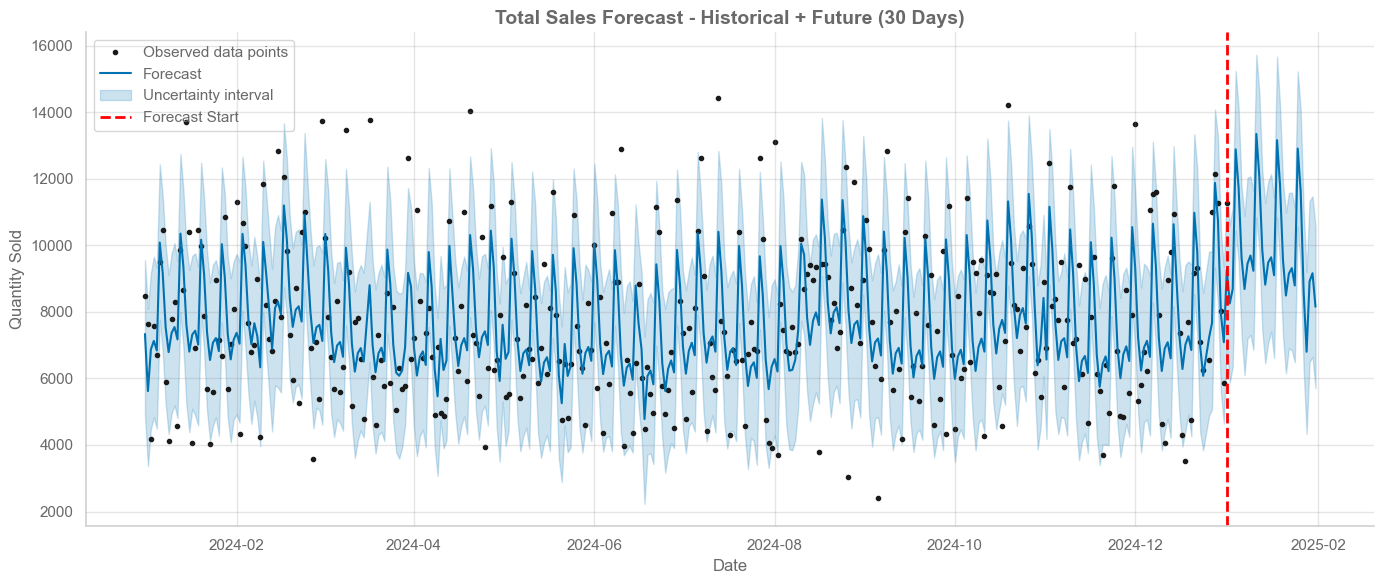

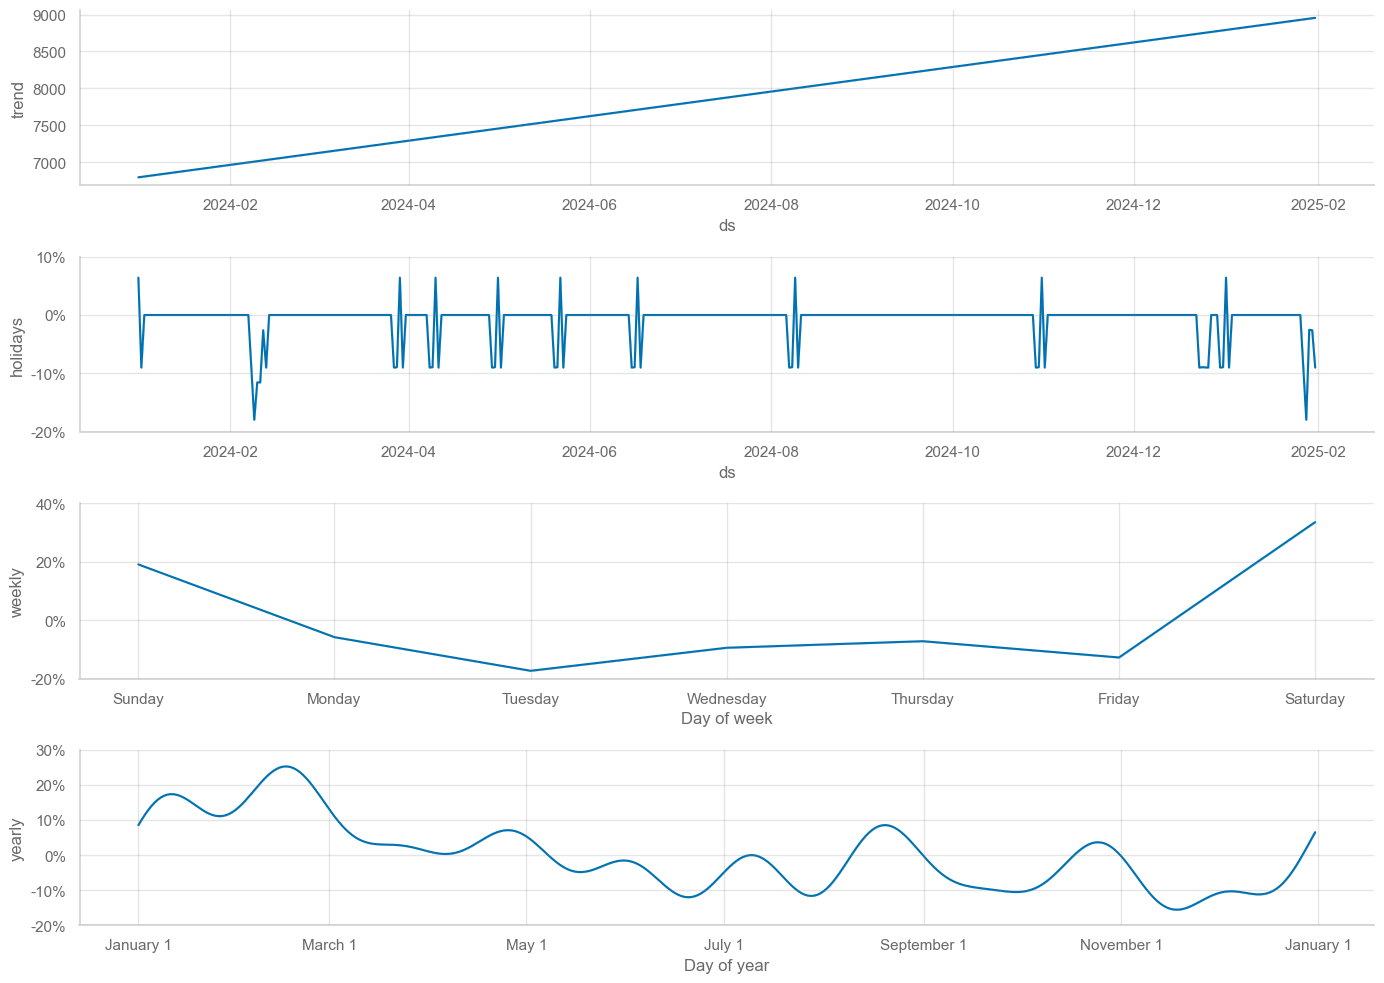


FUTURE FORECAST SUMMARY (Next 30 Days)
Forecast period: 2025-01-02 to 2025-01-31
Total forecast days: 30

Predicted daily sales statistics:
  Mean:   9903 units/day
  Median: 9383 units/day
  Min:    6803 units/day
  Max:    13350 units/day
  Std:    1699 units/day

Total predicted sales (30 days): 297077 units
Average confidence interval width: ±2381 units

📅 First 10 Days Forecast:
        ds     yhat  yhat_lower  yhat_upper
2025-01-02  8256.31     5870.10    10598.08
2025-01-03  8688.85     6351.51    11136.15
2025-01-04 12887.88    10443.32    15241.66
2025-01-05 11722.24     9511.21    14112.00
2025-01-06  9624.28     7306.34    11755.00
2025-01-07  8689.22     6101.05    10889.96
2025-01-08  9448.88     7199.20    12038.74
2025-01-09  9695.66     7306.84    12075.06
2025-01-10  9236.54     6854.83    11640.81
2025-01-11 13350.30    10841.82    15730.85

✅ Final forecasting complete!


In [67]:
# FINAL FORECASTING - Predict next 30 days using entire dataset
prediction_days = 30

print("=" * 60)
print("FINAL FORECASTING - FUTURE PREDICTIONS")
print("=" * 60)
print(f"Using all available data: {len(df_clean)} days")
print(f"Last date in dataset: {df_clean['date'].max().date()}")
print(f"Forecasting next {prediction_days} days")
print(f"Forecast end date: {(df_clean['date'].max() + timedelta(days=prediction_days)).date()}")

# Prepare data for Prophet
df_copy = df_clean[['date', 'quantity_sold']].copy()
df_copy.columns = ['ds', 'y']
df_copy['ds'] = pd.to_datetime(df_copy['ds'])
df_copy['y'] = df_copy['y'].apply(pd.to_numeric)

print(f"\nTraining final model on full dataset...")

# Initialize Prophet with best parameters + holidays
final_model = Prophet(
    changepoint_prior_scale=best['changepoint_prior_scale'],
    seasonality_prior_scale=best['seasonality_prior_scale'],
    seasonality_mode=best['seasonality_mode'],
    holidays=singapore_holidays_df,  # Include Singapore holidays
    holidays_prior_scale=10.0,
    changepoint_range=0.8,
    daily_seasonality=False,
    weekly_seasonality=True,
    yearly_seasonality=True
)

# Fit model on entire dataset
final_model.fit(df_copy)

# Make future predictions
future = final_model.make_future_dataframe(periods=prediction_days)
fcst_prophet = final_model.predict(future)

print(f"✅ Model trained successfully!")
print(f"Total predictions generated: {len(fcst_prophet)} days")

# Visualize forecast
print("\n📊 Generating visualizations...")

# Plot 1: Forecast with historical data
fig1 = final_model.plot(fcst_prophet, figsize=(14, 6))
plt.title('Total Sales Forecast - Historical + Future (30 Days)', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Quantity Sold', fontsize=12)
plt.axvline(x=df_clean['date'].max(), color='red', linestyle='--', linewidth=2, label='Forecast Start')
plt.legend()
plt.tight_layout()
plt.show()

# Plot 2: Components (Trend, Weekly, Yearly Seasonality)
fig2 = final_model.plot_components(fcst_prophet, figsize=(14, 10))
plt.tight_layout()
plt.show()

# Extract future forecasts only (next 30 days)
forecast_start_date = df_clean['date'].max()
forecasted_df = fcst_prophet[fcst_prophet['ds'] > forecast_start_date].copy()

print("\n" + "=" * 60)
print("FUTURE FORECAST SUMMARY (Next 30 Days)")
print("=" * 60)
print(f"Forecast period: {forecasted_df['ds'].min().date()} to {forecasted_df['ds'].max().date()}")
print(f"Total forecast days: {len(forecasted_df)}")
print(f"\nPredicted daily sales statistics:")
print(f"  Mean:   {forecasted_df['yhat'].mean():.0f} units/day")
print(f"  Median: {forecasted_df['yhat'].median():.0f} units/day")
print(f"  Min:    {forecasted_df['yhat'].min():.0f} units/day")
print(f"  Max:    {forecasted_df['yhat'].max():.0f} units/day")
print(f"  Std:    {forecasted_df['yhat'].std():.0f} units/day")

print(f"\nTotal predicted sales (30 days): {forecasted_df['yhat'].sum():.0f} units")
print(f"Average confidence interval width: ±{(forecasted_df['yhat_upper'] - forecasted_df['yhat_lower']).mean()/2:.0f} units")

# Display first 10 days of forecast
print("\n📅 First 10 Days Forecast:")
print(forecasted_df[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head(10).to_string(index=False))

print("\n✅ Final forecasting complete!")